Develops a custom convolutional neural network (CNN) to classify Alzheimer's disease, focusing on:
- Hyperparameter tuning to optimize model performance
- Distributed training using TensorFlow's MirroredStrategy
- The effect of class imbalance on class-specific classification accuracy

In [12]:
# "standard"
import numpy as np

# machine learning and statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# misc
from IPython.display import clear_output

# src
import sys, pickle, os
from pathlib import Path
script_dir = Path(os.getcwd()).parent
src_dir = script_dir / 'src'
sys.path.append(str(src_dir))
from visualize import visualize_training, multiclass_summary

clear_output(wait=False)

Create results directory

In [ ]:
script_dir = Path(os.getcwd()).parent
results_dir_00 = script_dir / 'results' / 'notebook_00'

results_dir_02 = script_dir / 'results' / 'notebook_02'
os.makedirs(results_dir_02, exist_ok=True)

In [4]:
# Load data file and unpack contents
file_name = results_dir_00 / 'data_preprocessed.pkl'
with open(file_name, 'rb') as f:
    data_preproc = pickle.load(f)

train_data=data_preproc['train_data']
train_lab=data_preproc['train_labels']
test_data=data_preproc['test_data']
test_lab=data_preproc['test_labels']
class_lab = ['Mild', 'Moderate', 'None', 'Very Mild']
    
# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

Define custom CNN and distributed training strategy

In [5]:
def create_model():
    # three convolutional layers and one fully connected layer
    model = keras.Sequential([
        keras.Input(shape = (128, 128, 1)),

        keras.layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(
            filters=64, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(
            filters=128, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'), # fully connected layer
        keras.layers.Dense(4, activation='softmax')
    ])
    return model

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = create_model()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

clear_output(wait=False)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,484 (24.86 MB)

 Trainable params: 6,516,484 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Fit model

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
validation_data = (test_data, test_lab_cat)

history = model.fit(
    train_data, 
    train_lab_cat, 
    epochs=25, 
    batch_size=32, 
    validation_data=validation_data, 
    callbacks=[early_stopping]
)

clear_output(wait=False)

In [7]:
# Save model and history files
model.save(results_dir_02 / 'model.h5')
print(f"Model saved to {results_dir_02 / 'model.h5'}")

file_name = results_dir_02 / 'history_custom_CNN.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(history, f)

print(f"Data saved to {file_name}")

Model saved to c:\Users\bedelman\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\model.h5
Data saved to c:\Users\bedelman\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\history_custom_CNN.pkl


Visualize model fit

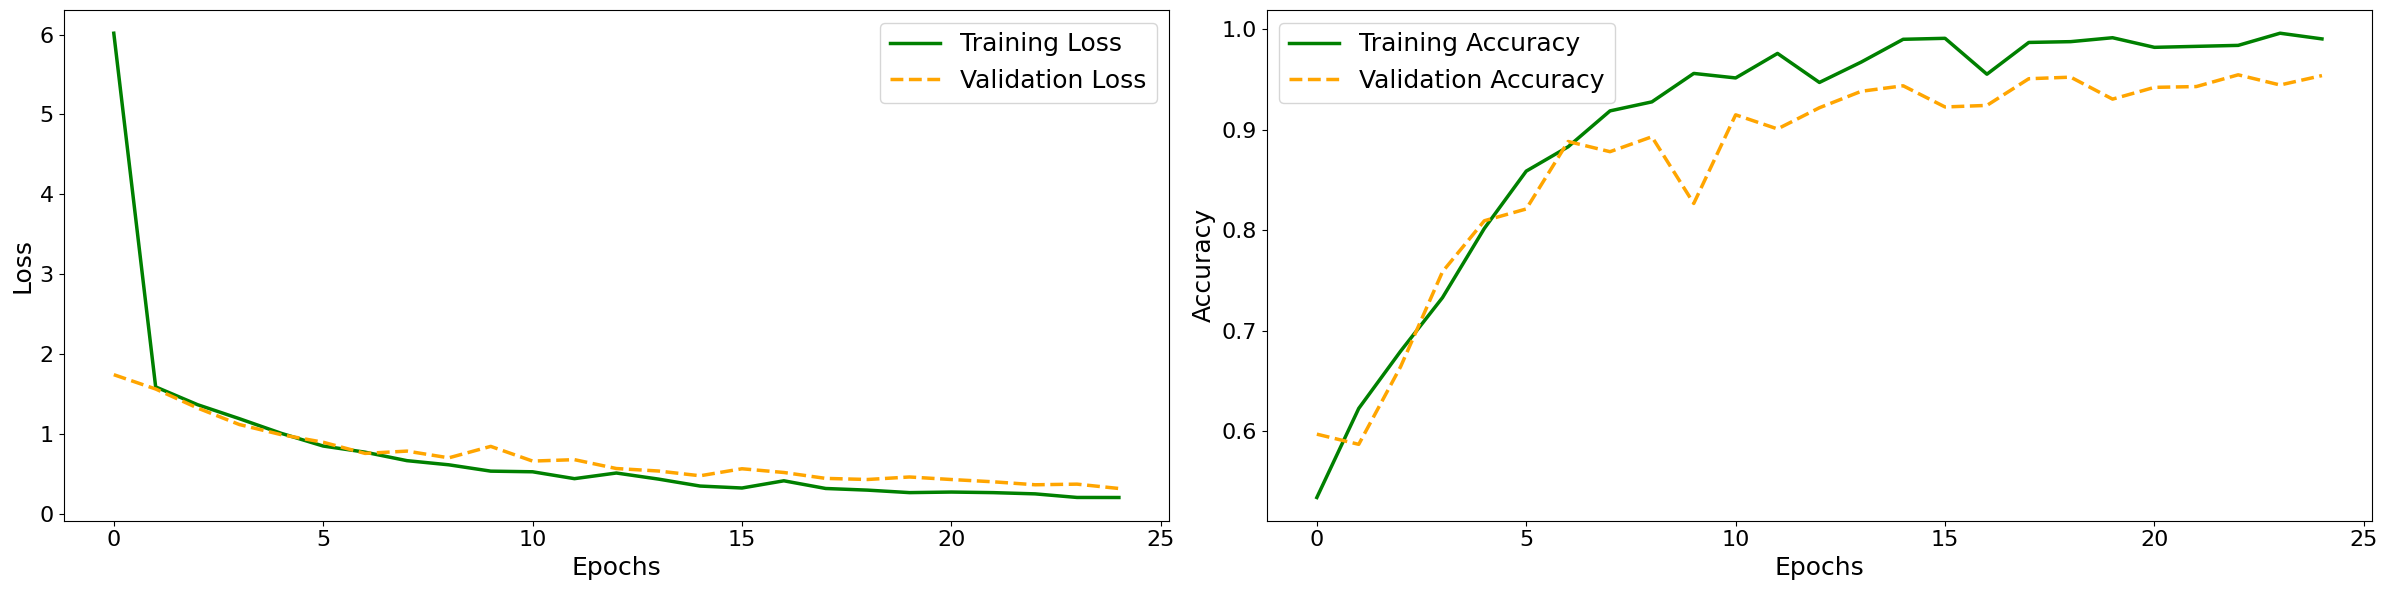

In [9]:
file_name = results_dir_02 / 'history_custom_CNN.pkl'
with open(file_name, 'rb') as f:
    history = pickle.load(f)
clear_output(wait=False)

visualize_training(history)

Predict test data, evaluate accuracy and visualize


Overall classification accuracy is: 95.39 %



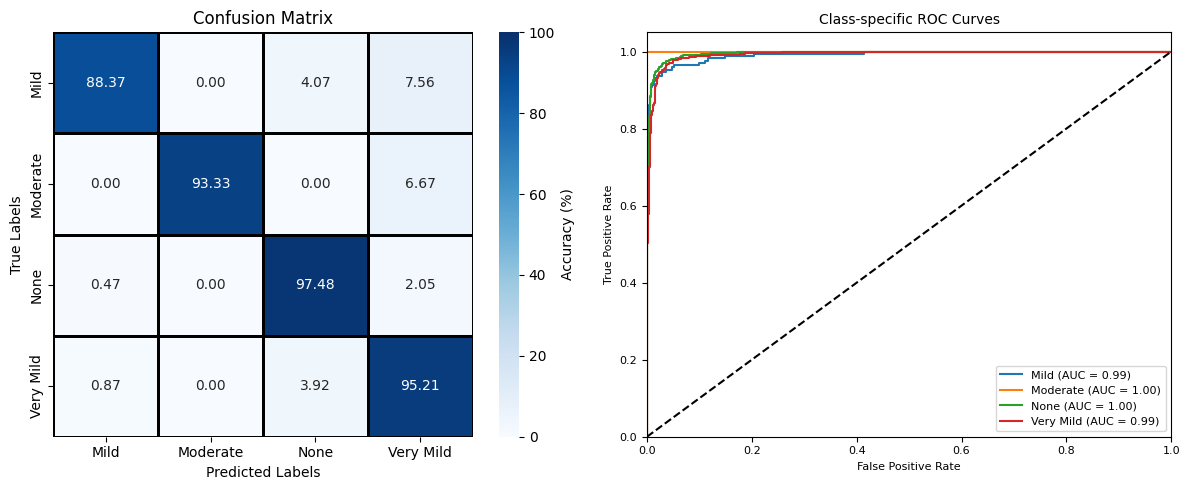

Mild - Precision: 0.96, Recall: 0.88, F1 Score: 0.92
Moderate - Precision: 1.00, Recall: 0.93, F1 Score: 0.97
None - Precision: 0.96, Recall: 0.97, F1 Score: 0.97
Very Mild - Precision: 0.94, Recall: 0.95, F1 Score: 0.95



In [13]:
# Load model
model = load_model(results_dir_02 / 'model.h5')

# Predict test data
prob = model.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()

Overall we do not see here a direct link between the test set class accuracies and the number of measurements in the training set. While the majority class (no AD) exhibited the highest accuracy, the minority class (moderate AD) exhibited the second highest.

Define hyperparameters to tune and the corresponding parameter space

In [14]:
# Same architecture as before, but with hyperparameter ranges
def build_model(hp):

    model = keras.Sequential([
    keras.Input(shape = (128, 128, 1)),  
        
    keras.layers.Conv2D(
        filters = hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 32), 
        kernel_size = hp.Choice('conv_1_kernel', values = [3,3]), 
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_2_filter', min_value = 64, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_2_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_3_filter', min_value = 96, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_3_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
        
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value = 128, max_value = 256, step = 32),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
        
    keras.layers.Dropout(0.5),
        
    keras.layers.Dense(4, activation = 'softmax')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

Initiate tuner

In [15]:
script_dir = Path(os.getcwd()).parent
tuner_dir = script_dir / 'results' / 'notebook_02' / 'tuner_dir'
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=20, factor=3, directory=tuner_dir, project_name='AD_class')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Run search

In [18]:
# Tune parameters on subset of data to conserve time/memory
subset = []
for label in np.unique(train_lab):
    label_indices = np.where(train_lab == label)[0]
    np.random.shuffle(label_indices)
    subset.extend(label_indices[:int(0.25 * len(label_indices))])
subset = np.array(subset)
train_data_tune = train_data[subset,:,:]
train_lab_tune = train_lab[subset]

# Plot bar graph of label distribution in subset
label_counts = np.bincount(train_lab_tune)
labels = np.arange(len(label_counts))

train_lab_tune_cat = to_categorical(train_lab_tune.astype('int8'))
test_data_tune = test_data
test_lab_tune_cat = to_categorical(test_lab.astype('int8'))

In [19]:
tuner.search(
    train_data_tune,
    train_lab_tune_cat,
    epochs = 10,
    callbacks = [stop_early],
    validation_data = (test_data_tune, test_lab_tune_cat)
)

Trial 2 Complete [00h 01m 43s]
val_accuracy: 0.5445312261581421

Best val_accuracy So Far: 0.5445312261581421
Total elapsed time: 00h 03m 09s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |32                |conv_1_filter
3                 |3                 |conv_1_kernel
64                |128               |conv_2_filter
3                 |3                 |conv_2_kernel
128               |128               |conv_3_filter
3                 |3                 |conv_3_kernel
192               |160               |dense_1_units
0.001             |0.001             |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 940ms/step - accuracy: 0.4316 - loss: 25.8442 - val_accuracy: 0.5016 - val_loss: 4.4041
Epoch 2/3
18/40 ━━━━━

KeyboardInterrupt: 

Even though this accuracy is lower than expected given the previous results, tuning was performed on a subset of training data and with limited training epochs to conserve time and memory. Nevertheless, training data was randomly sampled and should be representative of the total dataset. Therefore, we will use the best hyperparameters found here for further model training.

In [0]:
# Optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Save best hyperparameters
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/best_hps_custom_CNN.pkl'
save_pickle_s3(best_hps, bucket_name, s3_file_path, dbutils)

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/best_hps_custom_CNN.pkl


In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/best_hps_custom_CNN.pkl'
best_hps = load_pickle_s3(bucket_name, s3_file_path, dbutils)

print(f"""
Optimal parameters are as follows:

Filter 1 output dim: {best_hps.get('conv_1_filter')}
Filter 2 output dim: {best_hps.get('conv_2_filter')}
Filter 3 output dim: {best_hps.get('conv_3_filter')}

Dense layer units: {best_hps.get('dense_1_units')}

Learning Rate: {best_hps.get('learning_rate')}
""")


Optimal parameters are as follows:

Filter 1 output dim: 96
Filter 2 output dim: 64
Filter 3 output dim: 128

Dense layer units: 224

Learning Rate: 0.0001



Re-train with full training data and optimal hyperparameters

In [0]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_data,
    train_lab_cat,
    epochs = 25,
    callbacks = [stop_early],
    validation_data = (test_data, test_lab_cat),
    )

clear_output(wait=False)

In [0]:
# Save model and history files
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_custom_CNN_best_hp.h5'
save_model_s3(model, bucket_name, s3_file_path, dbutils)

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_custom_CNN_best_hp.pkl'
save_pickle_s3(history, bucket_name, s3_file_path, dbutils)

Model uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucketAD_MRI_classification/results/model_custom_CNN_best_hp.h5
Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/history_custom_CNN_best_hp.pkl


Best epoch: 20


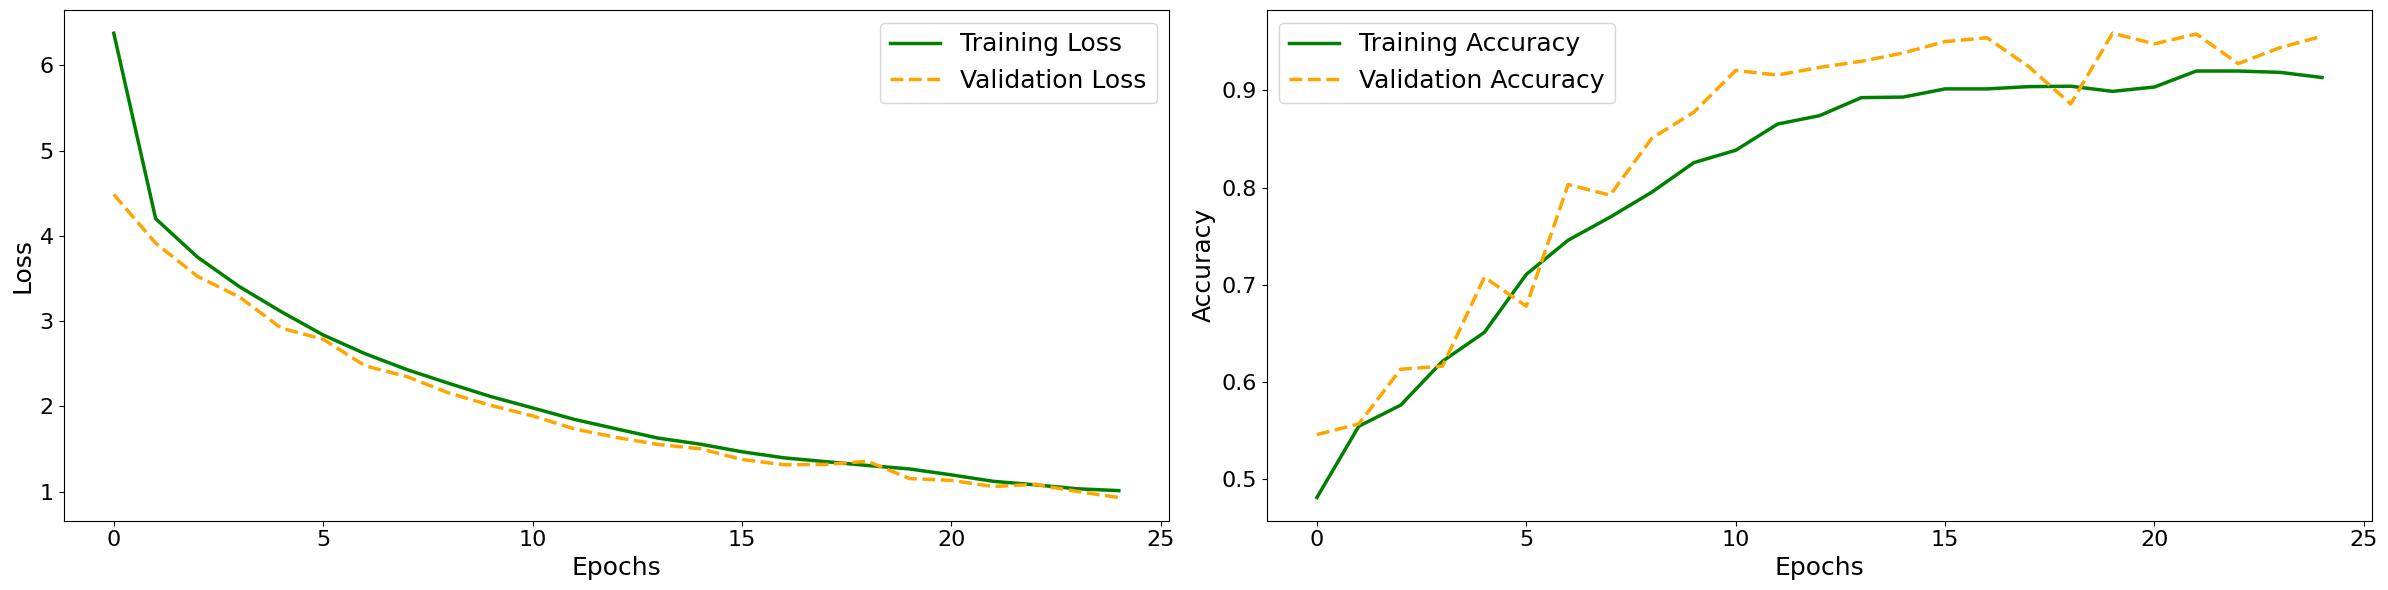

In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_custom_CNN_best_hp.pkl'
history = load_pickle_s3(bucket_name, s3_file_path, dbutils)
clear_output(wait=False)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

visualize_training(history)

When compared to the original training strategy, that with optimal hyperparameters clearly maximizes the test accuracy across training. However, lets examine model fit in more detail.


Overall classification accuracy is: 95.55 %



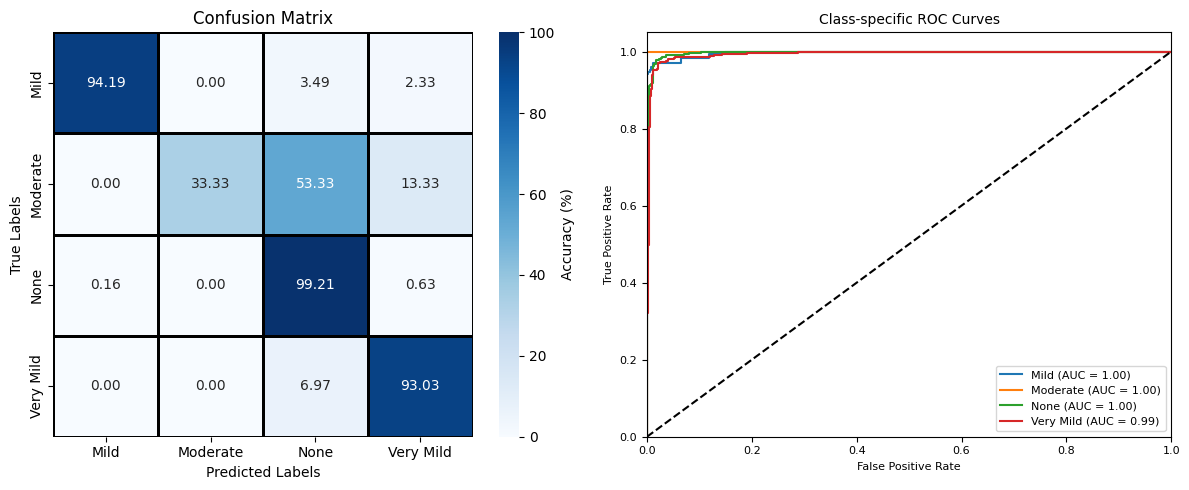

Mild - Precision: 0.99, Recall: 0.94, F1 Score: 0.97
Moderate - Precision: 1.00, Recall: 0.33, F1 Score: 0.50
None - Precision: 0.93, Recall: 0.99, F1 Score: 0.96
Very Mild - Precision: 0.98, Recall: 0.93, F1 Score: 0.95



In [0]:
# Load model
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_custom_CNN_best_hp.h5'
model=load_model_s3(bucket_name, s3_file_path, dbutils)

# Predict test data
prob = model.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()

Even thought hyperparameter tuning (slightly) improved overall classification accuracy, we now see that there is significant bias on a per-class basis. In particular, the moderate AD class, which by far the minority class in the entire dataset, clearly exhibits the worst performance and is difficult to distinguish from no AD. This is problematic since these conditions are on the opposite ends of the AD spectrum in this dataset. Ideally, we devise a model that can distinguish all classes.